# Analysis of SpikeGadgets Neuropixels Dataset

1. Specifying the recording directory
2. Read probe settings from the raw file
3. Generate inter-sample shift
4. Convert the exported file into a binary file
5. Load the binary file

## Current issues
- Inter_sample_shift: The original function to compute inter sample shifts, get_inter_sample_shift, set the parameter of total number of channels as 384. How should we use the generated inter sample shifts for the recordings with less than 384 channels?
- ~~Preprocessing of common referenced data: The CommonReferenceRecording object cannot be processed properly with `detect_peaks` and `localize_peaks`. The python raises the error `AssertionError: 'inter_sample_shift' is not a property!` and crushes when these functions are run for the processed recording object. It cannot be solved by adding `inter_sample_shift` property to the object.~~
- ~~Set Probe: `ValueError: The given Probe have 'device_channel_indices' that do not match channel count `~~
  It was solved by assigning the 0-index global indices to each channel.
- 500 Server Error when running kilosort using Docker for the recording in the network drive. Temporarily, run the docker kilosort in local drives.
- The channels of kilosort .dat files generated by SpikeGadgets system are in descending order. On the other hand, the curren codes generate the probe map in ascending order of the depth. Temporarily, the code was fixed so that the probe for kilosort is in descending order. The codes to generate concatenated binary have not been fixed so that its structure match with kilosort binary.

## Recording directory

In [1]:
# rec_dir = 'E:/Dataset/KQTY/GridBat/32622/flight_room/231006/ephys/20231006_152611.rec'

In [1]:
# rec_dir = 'C:/Users/Tatsumi/Documents/Data/KQTY_NP/32622/flight_room/231007/ephys/20231007_133453.rec'

In [1]:
# rec_dir = 'Z:/users/Tatsumi/data/NP_Kevin/GridBat/32622/flight_room/231007/20231007_133453.rec'

In [1]:
rec_dir = 'C:/Users/Tatsumi/Documents/Data/KQTY_NP/32622/flight_room/231007/ephys/split_1min'

In [2]:
# rec_dir = 'C:/Users/Tatsumi/Documents/Data/KQTY_NP/32623/20230907_161730.rec'

In [3]:
# rec_dir = 'C:/Users/Tatsumi/Documents/Data/KQTY_NP/32623/20230907_1min'

## Library

In [2]:
import glob,sys,os, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw


from probeinterface import read_prb

In [3]:
# Other settings
# Setting for parallel processing
global_job_kwargs = dict(n_jobs=4, chunk_duration="5s")
si.set_global_job_kwargs(**global_job_kwargs)

%matplotlib inline

## Preprocessing

In [4]:
# store results
rez = {}

rec_dir = Path(rec_dir) # recording directory
rec_path = Path(glob.glob('{}/*.trodesconf'.format(rec_dir))[0]) # path of .rec file
# save
rez['recording'] = rec_dir 
rez['rec_file'] = rec_path
rez['processed'] = rec_dir.joinpath('processed')
if not os.path.exists(rez['processed']):
    os.mkdir(rez['processed'])

print(rez)

{'recording': WindowsPath('C:/Users/Tatsumi/Documents/Data/KQTY_NP/32622/flight_room/231007/ephys/split_1min'), 'rec_file': WindowsPath('C:/Users/Tatsumi/Documents/Data/KQTY_NP/32622/flight_room/231007/ephys/split_1min/20231007_133453_merged_1min.trodesconf'), 'processed': WindowsPath('C:/Users/Tatsumi/Documents/Data/KQTY_NP/32622/flight_room/231007/ephys/split_1min/processed')}


### Read probe settings from the raw file

In [5]:
def get_probegroup_np(rez):
    import glob,sys,os
    import numpy as np
    from xml.etree import ElementTree
    import re
    from probeinterface import Probe, ProbeGroup, write_prb
    from probeinterface.plotting import plot_probe, plot_probe_group

    rec_file_path = rez['rec_file']
    
    header_size = None
    with open(rec_file_path, mode='rb') as f:
        while True:
            line = f.readline()
            if b"</Configuration>" in line:
                header_size = f.tell()
                break
        if header_size is None:
            ValueError("SpikeGadgets: the xml header does not contain '</Configuration>'")

        f.seek(0)
        header_txt = f.read(header_size).decode('utf8')

    # explore xml header
    root = ElementTree.fromstring(header_txt)
    # gconf = sr = root.find('GlobalConfiguration')
    hconf = root.find('HardwareConfiguration')
    sconf = root.find('SpikeConfiguration')

    # Number of channels for each probe
    sources = hconf.findall("SourceOptions")
    num_probe = len(sources)
    num_chans = np.zeros((num_probe))
    for pr in range(num_probe):
        source = sources[pr]
        source_id = source.attrib['name']
        options = source.findall("CustomOption")
        for option in options:
            if option.attrib['name'] == 'channelsOn':
                probe_map = option.attrib['data']
                probe_map = [int(ch) for ch in probe_map.split()]
                num_chans[pr] = sum(probe_map)
    rez['num_probe'] = num_probe
    rez['num_channels'] = num_chans
    # print(num_chans)

    # Get channel info
    # chan_map = np.zeros((int(sum(num_chans)),5))
    chan_map = []
    for trode in sconf:
        for schan in trode:
            pr = int(schan.attrib['spikeSortingGroup'])
            id = int(trode.attrib['id']) - 1000*(pr+1)
            hwchan = int(schan.attrib['hwChan'])
            x = int(schan.attrib['coord_ml'])
            y = int(schan.attrib['coord_dv'])
            ap = int(schan.attrib['coord_ap'])

            chan_map.append((x,y,pr,id,hwchan))
    chan_map = np.asarray(chan_map)
    chan_map = pd.DataFrame(chan_map,columns=['x','y','probe','id','hwChan'])
    # print('Probe configuration:')
    # print(chan_map)

    device_indices = [i for i in range(len(chan_map))]
    chan_map['id_new'] = device_indices
    print(chan_map)
    
    # Generate NP probes
    probes = []
    start_id = 0
    for pr in range(num_probe):
        chan_map_new = chan_map[chan_map['probe']==pr]
        # probe channel indices should be 0-indexed
        # Caution! This part is not appropriate. The kilosort dat file is 
        # organized in the descending order of the depth. This part should be
        # fixed in the future.

        # chan_map_old = chan_map[chan_map['probe']==pr]
        # chan_map_new = chan_map_old.sort_values('id')
        # chan_id_new = [i for i in range(start_id,start_id + len(chan_map_old))]
        # start_id = np.max(chan_id_new) + 1
        # chan_map_new['id_new'] = chan_id_new


        # Set probe
        positions = chan_map_new[chan_map_new['probe']==pr][['x','y']]
        shank_ids = np.ones(int(num_chans[pr])) * pr
        probe = Probe(ndim=2, si_units='um')
        probe.set_contacts(positions=positions, 
                           shapes='circle',
                           shape_params={'radius': 5},
                           shank_ids=shank_ids)
        # Set device channel indices
        channel_indices = chan_map_new['id_new'].to_numpy()
        probe.set_device_channel_indices(channel_indices)
        # Set contact ids
        contact_ids = chan_map_new['id'] + 1000*(pr+1)
        probe.set_contact_ids(contact_ids=contact_ids)
        # Append probe
        probes.append(probe)

    # Generate probe groups
    probegroup = ProbeGroup()
    for probe in probes:
        probegroup.add_probe(probe)

    # Plot probe contacts
    plot_probe_group(probegroup, same_axes=False, with_channel_index=False)
    plt.show()

    # Save probes
    output_path = rez['processed'].joinpath('probe.prb')
    rez['probe_map'] = output_path
    print('Probe file is written as ' + str(output_path))
    write_prb(file=output_path,probegroup=probegroup)

    return rez

In [6]:
rez = get_probegroup_np(rez)

      x     y  probe   id  hwChan  id_new
0    -8  3600      0  352     477       0
1    24  3600      0  351     476       1
2   -24  3580      0  350     413       2
3     8  3580      0  349     412       3
4    -8  3560      0  348     349       4
..   ..   ...    ...  ...     ...     ...
379   8  1980      1  189     686     379
380  -8  1960      1  188     623     380
381  24  1960      1  187     622     381
382 -24  1940      1  186     559     382
383   8  1940      1  185     558     383

[384 rows x 6 columns]


Probe file is written as C:\Users\Tatsumi\Documents\Data\KQTY_NP\32622\flight_room\231007\ephys\split_1min\processed\probe.prb


### Generate inter-sample shift

Spikeinterface recording objects require the property called `inter_sample_shift` to handle with Neuropixels data. 
  
This is supposed to be the shift of sampling phase due to Neuropixels ADC multiplexing.  
The current script to generate the inter-sample shift is based on the module in `neuropixels_utils` in the extractors module of the Spikeinterface.  
  
I need to check it in more detail if this processing is appropriate.

Below is the description of inter-sample shifts in `neuropixels_utils` in spikeinterface.  

--------------------------------------  
__Generate sample shift (inter_sample_shift?)__  
Calculates the relative sampling phase of each channel that results from Neuropixels ADC multiplexing.

This information is needed to perform the preprocessing.phase_shift operation.

See https://github.com/int-brain-lab/ibllib/blob/master/ibllib/ephys/neuropixel.py for the original implementation.

__Parameters__
- num_channels : int, default: 384  
The total number of channels in a recording. All currently available Neuropixels variants have 384 channels.  
- num_channels_per_adc : int, default: 12  
The number of channels per ADC on the probe.  
Neuropixels 1.0 probes have 12 ADCs.  
Neuropixels 2.0 probes have 16 ADCs.  
- num_cycles: int or None, default: None  
The number of cycles in the ADC on the probe.  
Neuropixels 1.0 probes have 13 cycles for AP and 12 for LFP.  
Neuropixels 2.0 probes have 16 cycles.  
If None, the num_channels_per_adc is used.  

__Returns__  
- sample_shifts : ndarray  
The relative phase (from 0-1) of each channel  

In [7]:
def compute_global_sample_shift(stream):
    # Generate sample shift across electrodes
    num_channels = 384
    num_channels_per_adc = 12
    if stream == 'LFP':
        num_cycles = 13 # AP
    if stream == 'spikeband':
        num_cycles = 12 # LFP
    
    adc_indices = np.floor(np.arange(num_channels) / (num_channels_per_adc*2))*2    \
            + np.mod(np.arange(num_channels), 2)
    
    sample_shifts = np.zeros_like(adc_indices)
    for a in adc_indices:
        sample_shifts[adc_indices == a] = np.arange(num_channels_per_adc) / num_cycles

    return sample_shifts

def compute_iss(rez):
    streams = ['LFP','spikeband']
    if not 'probe_map' in rez:
        print('Probe map was not found.')
    if 'probe_map' in rez:
        probegroup = read_prb(rez['probe_map'])
        rez['inter_sample_shift'] = {}
        for pr in range(rez['num_probe']):
            out_dir = rez['processed'].joinpath('probe{}'.format(pr+1))
            if not os.path.exists(out_dir):
                os.mkdir(out_dir)
            probe = probegroup.probes[pr]
            num_chan = probe.get_contact_count()
            inter_sample_shift = np.zeros(num_chan)
            enabled_chans = probe.device_channel_indices
    
            rez['inter_sample_shift']['probe{}'.format(pr+1)] = {}
            for stream in streams:
                sample_shifts = compute_global_sample_shift(stream)
                for i in range(len(enabled_chans)):
                    inter_sample_shift[i] = sample_shifts[enabled_chans[i]%384-1]
                    
                # Save to npy file
                out_path = out_dir.joinpath('inter_sample_shift_probe{}_{}.npy'.format(pr+1,stream))
                np.save(out_path,inter_sample_shift)
                # save
                rez['inter_sample_shift']['probe{}'.format(pr+1)]['{}'.format(stream)] = inter_sample_shift

In [8]:
compute_iss(rez)

### Convert the exported file into a binary file

The original trodes function `readTrodesExtractedDataFile3` cannot be imported because of the error caused by the testing function in the script. This is because the new version of NumPy does not support some syntax any more.  
To load the data exported by Trodes, import and run the function copied and fixed for the part causing the error.

In [12]:
def convert_spikegadgets_dat2binary(rez,stream):
    from tqdm import tqdm
    
    rec_dir = rez['recording']
    # Trodes function for data interface
    trodes_dir = 'C:/Users/Tatsumi/Documents/GitHub/Neuropixels_spikegadgets_analysis/python/fromTrodes/' # path of Trodes python functions
    sys.path.append(trodes_dir)
    from readTrodesExtractedDataFile3 import readTrodesExtractedDataFile as readTrodes
    
   
    # Load the signals and timestamps for individual probe. Then, concatenate all channels into a binary data.
    # streams = ['LFP', 'spikeband']
    
    # for stream in streams:
    if stream == 'LFP':
        stream_dir = Path(glob.glob('{}/*.LFP'.format(rec_dir))[0])
    if stream == 'spikeband':
        stream_dir = Path(glob.glob('{}/*.spikeband'.format(rec_dir))[0])
    print('Processing the stream {}...'.format(stream))
    # gain = 50
    # scale_to_uv = (600/32767)*(1000/gain)

    # Make directory for binary data
    file_header = stream_dir.parts[-1].split('.')[0]
    binary_dir = rec_dir.joinpath('{}.binary'.format(file_header))
    if not os.path.exists(binary_dir):
        os.mkdir(binary_dir)

    # Num of channels
    num_chans = np.zeros(3)
    for probe in range(3):
        # num_chans[probe] = int(len(glob.glob(stream_dir+'/*nt'+str(probe+1)+'*')))
        num_chans[probe] = int(len(glob.glob('{}/*nt{}*'.format(stream_dir,probe+1))))
        print('Probe {} has {} channels'.format(probe+1,int(num_chans[probe])))
    num_probe = sum(i > 0 for i in num_chans) # number of probes
    
    # Make a list of all dat files
    stream_file = {}
    for probe in range(num_probe):
        stream_file[probe] = {}
        stream_file[probe]['file_path'] = glob.glob('{}/*nt{}*'.format(stream_dir,probe+1)) # files are sorted in ascending order
    
    # Load timestamps
    ts_file = glob.glob('{}/*timestamps*'.format(stream_dir))
    ts_data = readTrodes(ts_file[0])
    ts_lfp = ts_data['data']
    print('Timestamps has {} samples'.format(ts_lfp.size))
    
    # concatenate data and write into a binary file
    for probe in range(num_probe):
        binary_mmap_filename = os.path.join(binary_dir,'{}.{}_mmap_probe{}.dat'.format(file_header,stream,probe+1))
        if os.path.isfile(binary_mmap_filename):
            print('The stream {} for probe {} already exists.'.format(stream,probe+1))
        if not os.path.isfile(binary_mmap_filename):
            
            f = np.memmap(binary_mmap_filename, dtype='int16', mode='w+', shape=(int(num_chans[probe]),ts_lfp.size))
            for ch in tqdm(range(int(num_chans[probe])), desc="Loading data..."):
                f[ch,:] = readTrodes(stream_file[probe]['file_path'][ch])['data']

            print(f.shape)
            print(f)
            f = f.transpose()
            f = f.reshape((1,f.size))        
            print(f.shape)
            print(f)
            del f
            
            print('-----------------------')
            print('The stream {} for probe {} was converted into a binary file.'.format(stream,probe+1))
            
        print('The path of the binary file is {}'.format(binary_mmap_filename))

In [13]:
convert_spikegadgets_dat2binary(rez,'LFP')

IndexError: list index out of range

In [ ]:
convert_spikegadgets_dat2binary(rez,'spikeband')
# Current function cannot save the binary file larger than the system memory size

Processing the stream spikeband...
Probe 1 has 192 channels
Probe 2 has 192 channels
Probe 3 has 0 channels


C:\Users/Tatsumi/Documents/GitHub/Neuropixels_spikegadgets_analysis/python/fromTrodes\readTrodesExtractedDataFile3.py:65: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


Timestamps has 195711745 samples


Loading data...: 100%|███████████████████████████████████████████████████████████████| 192/192 [50:51<00:00, 15.89s/it]


(192, 195711745)
[[ -384   320  -128 ...   512   640  1024]
 [ -192   128 -1024 ...  -512   192  -832]
 [ -320 -1088  -960 ...   128  -320 -1152]
 ...
 [-1408   192  -192 ...  2304  1984  2304]
 [  256 -1024 -1920 ...  2624  1920  2816]
 [-1088 -1472 -1984 ...  4736  3904  3840]]


### Load the binary file

Data for Neuropixels recordings using SpikeGadgets system is not supported with the Spikeinterface. Non-Neuropixels SpikeGadgets data is supported, but the Neuropixels data structure is different from the non-Neuropixels one.  
Instead of loading the Neuropixels recording file directly, we can load the data following these steps:  
1. Extract the desired frequency band from the original raw file using the SpikeGadgets export utility. The voltage traces for individual channels are saved as separate .dat files.  
2. Concatenate these .dat files across channels and convert into a binary file. The binary file should not have any header. The data structure of the binary file is (N x M) as N is the number of channels and M is the number of samples. Please see `Convert_SpikeGadgets_dat2binary.ipynb` for more detail.
3. Load the binary file using the Spikeinterface `read_binary` function.  

In [9]:
rez['fs_ap'] = 30000
rez['fs_lfp'] = 1500
rez['dtype'] = 'int16'
rez['gain_LFP'] = 125
rez['gain_AP'] = 1000
rez['gain_to_uV'] = (600/32767.0)*(1000/rez['gain_LFP'])*64/64 # Should be checked how affect the data
rez['offset_to_uV'] = (600/32767.0)*(1000/rez['gain_AP'])*64/64 # Should be checked how affect the data

In [10]:
# from spikeinterface.extractors.neuropixels_utils import get_neuropixels_sample_shifts

# streams = ['LFP','spikeband','kilosort']
probe_id = 1 # 1~3
# stream = 'spikeband'
stream = 'kilosort'
# stream = 'LFP'

rec_dir = rez['recording']
if stream == 'spikeband' or stream == 'LFP':
    binary_path = Path(glob.glob('{}/*binary/*{}*probe{}*'.format(rec_dir,stream,probe_id))[0])
if stream == 'kilosort':
    binary_path = Path(glob.glob('{}/*kilosort/*merged*.probe{}*'.format(rec_dir,probe_id))[0])

# Recording settings
if stream == 'spikeband' or stream == 'kilosort':
    sampling_frequency = rez['fs_ap']
if stream == 'LFP':
    sampling_frequency = rez['fs_lfp']

dtype = rez['dtype']
num_channels = int(rez['num_channels'][probe_id-1])
gain_to_uV = rez['gain_to_uV']
offset_to_uV = rez['offset_to_uV']


# Read binary data as a spikeinterface recording structure
data = si.read_binary(binary_path,
                      sampling_frequency=sampling_frequency,
                      dtype=dtype,
                      num_channels=num_channels,
                      gain_to_uV=gain_to_uV,
                      offset_to_uV=offset_to_uV)

# Set inter sample shift to the recording object
if stream == 'spikeband' or stream == 'LFP':
    inter_sample_shift = rez['inter_sample_shift']['probe{}'.format(probe_id)]['{}'.format(stream)]
if stream == 'kilosort':
    inter_sample_shift = rez['inter_sample_shift']['probe{}'.format(probe_id)]['spikeband']
data.set_property('inter_sample_shift',inter_sample_shift)

# # Generate inter sample shift using built-in function
# total_channels = 384
# num_cycles = 200
# num_channels_per_adc = 12 # for NP1, 16 for NP2
# # compute inter_sample_shifts
# inter_sample_shift = get_neuropixels_sample_shifts(total_channels, num_channels_per_adc, num_cycles)
# data.set_property("inter_sample_shift", inter_sample_shift)

print('{} of probe {} was loaded from {}'.format(stream,probe_id,binary_path))
print(data)

kilosort of probe 1 was loaded from C:\Users\Tatsumi\Documents\Data\KQTY_NP\32622\flight_room\231007\ephys\split_1min\20231007_133453_merged_1min.kilosort\20231007_133453_merged_1min.probe1.dat
BinaryRecordingExtractor: 192 channels - 30.0kHz - 1 segments - 1,426,610 samples - 47.55s 
                          int16 dtype - 522.44 MiB
  file_paths: ['C:\\Users\\Tatsumi\\Documents\\Data\\KQTY_NP\\32622\\flight_room\\231007\\ephys\\split_1min\\20231007_133453_merged_1min.kilosort\\20231007_133453_merged_1min.probe1.dat']


### Set probe

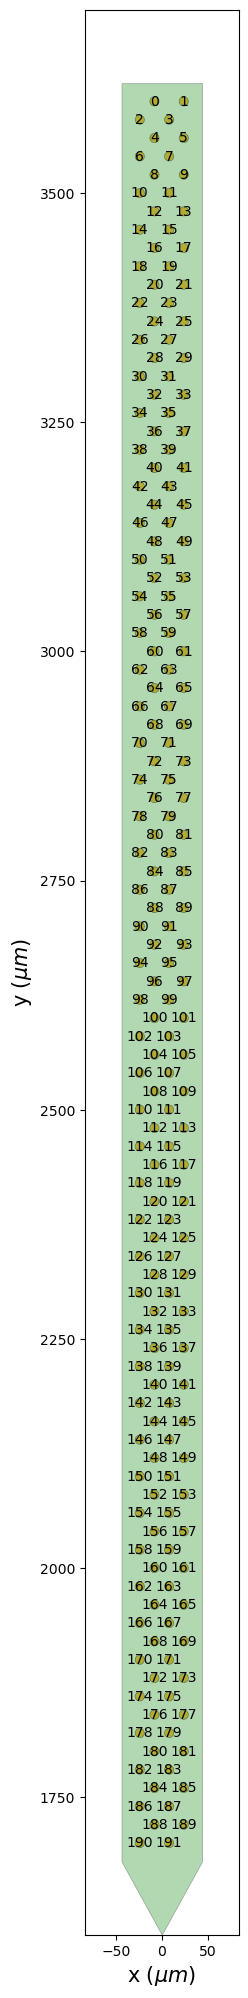

In [11]:
# Set probe
probegroup = read_prb(rez['probe_map'])
probe = probegroup.probes[probe_id-1]
data.set_probe(probe, in_place=True)
data.get_probe()

# Visualize probe contacts
fig, ax = plt.subplots(figsize=(5, 25))
sw.plot_probe_map(data, ax=ax, with_channel_ids=True)
y_max = np.max(probe.contact_positions[:,1])
y_min = np.min(probe.contact_positions[:,1])
ax.set_ylim(y_min-100, y_max+100)
plt.show()

In [12]:
chan_list = [i for i in range(3)]
data_new = data.channel_slice(chan_list)
data_new.channel_ids

array([0, 1, 2])

In [13]:
data.get_traces(channel_ids=chan_list)

array([[  960,   576,  2752],
       [  768,    64,   320],
       [ 2112,  -192,  -128],
       ...,
       [-1216,  1088,  -896],
       [  256,  1536,    64],
       [  896,   832,   768]], dtype=int16)

In [14]:
probe = data_new.get_probe()

In [15]:
probe.contact_positions

array([[  -8., 3600.],
       [  24., 3600.],
       [ -24., 3580.]])

### Filtering

In [16]:
data_processed = data
if data.is_filtered():
    print('Data is already filtered')
if not data.is_filtered():
    data_processed = spre.highpass_filter(data_processed, freq_min=300.)
# bad_channel_ids, channel_labels = spre.detect_bad_channels(data_processed)
# data_processed = data_processed.remove_channels(bad_channel_ids)
# print('bad_channel_ids', bad_channel_ids)
if stream == 'LFP' or stream == 'spikeband':
    inter_sample_shift = rez['inter_sample_shift']['probe{}'.format(probe_id)]['{}'.format(stream)]
if stream =='kilosort':
    inter_sample_shift = rez['inter_sample_shift']['probe{}'.format(probe_id)]['spikeband']
data_processed = spre.phase_shift(data_processed, inter_sample_shift=inter_sample_shift)
data_processed = spre.common_reference(data_processed, operator="median", reference="global")

data = data_processed
data.get_property_keys()

['gain_to_uV',
 'offset_to_uV',
 'inter_sample_shift',
 'contact_vector',
 'location',
 'group']

### Save processed recording (optional)

In [ ]:
job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)

data_processed = data.save(folder=rez['processed'].joinpath('temp_binary'),
                                     format='binary', **job_kwargs)

In [44]:
# file_path = rez['recording'].joinpath('temp_binary')
# data_loaded = si.load_extractor(file_path)

### Check noise level

In [21]:
# we can estimate the noise on the scaled traces (microV) or on the raw one (which is in our case int16).
noise_levels_microV = si.get_noise_levels(data, return_scaled=True)
noise_levels_int16 = si.get_noise_levels(data, return_scaled=False)

In [22]:
fig, ax = plt.subplots()
# _ = ax.hist(noise_levels_microV, bins=np.arange(5, 30, 2.5))
_ = ax.hist(noise_levels_microV)
ax.set_xlabel('noise  [uV]')

Text(0.5, 0, 'noise  [uV]')

Text(0.5, 0, 'noise  [raw]')

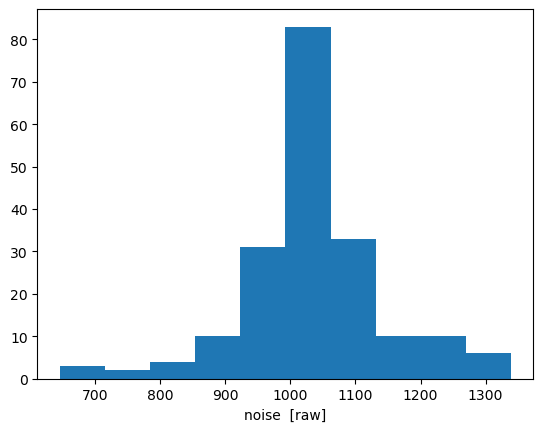

In [23]:
fig, ax = plt.subplots()
# _ = ax.hist(noise_levels_microV, bins=np.arange(5, 30, 2.5))
_ = ax.hist(noise_levels_int16)
ax.set_xlabel('noise  [raw]')

### Detect and localize peaks

In [24]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
# detect_threshold: Threshold, in median absolute deviations (MAD), to use to detect peaks.
# noise_levels: Estimated noise levels to use, if already computed.
# local_radius_um: The radius to use to select neighbour channels for locally exclusive detection.

job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
peaks = detect_peaks(data,  method='locally_exclusive', noise_levels=noise_levels_int16,
                     detect_threshold=5, local_radius_um=50., **job_kwargs)
peaks

detect peaks using locally_exclusive:   0%|          | 0/48 [00:00<?, ?it/s]

array([(      5, 179, -13571., 0), (     13, 179,  -7679., 0),
       (     15,  62,  -5804., 0), ..., (1425353, 181,  -7159., 0),
       (1425512, 181,  -6662., 0), (1426606,  53,  -5574., 0)],
      dtype=[('sample_index', '<i8'), ('channel_index', '<i8'), ('amplitude', '<f8'), ('segment_index', '<i8')])

In [25]:
filename = rez['processed'].joinpath('probe{}'.format(probe_id),'peaks.npy')
np.save(filename,peaks)

In [27]:
from spikeinterface.sortingcomponents.peak_localization import localize_peaks
# Detect the locations of peaks
# Return contains the x and the y position of peaks
job_kwargs = dict(n_jobs=20, chunk_duration='2s', progress_bar=True)
peak_locations = localize_peaks(data, peaks, method='center_of_mass', local_radius_um=50., **job_kwargs)

localize peaks using center_of_mass:   0%|          | 0/24 [00:00<?, ?it/s]

In [28]:
filename = rez['processed'].joinpath('probe{}'.format(probe_id),'peak_locations.npy')
np.save(filename,peak_locations)

### Check for drifts

In [29]:
peaks

array([(      5, 179, -13571., 0), (     13, 179,  -7679., 0),
       (     15,  62,  -5804., 0), ..., (1425353, 181,  -7159., 0),
       (1425512, 181,  -6662., 0), (1426606,  53,  -5574., 0)],
      dtype=[('sample_index', '<i8'), ('channel_index', '<i8'), ('amplitude', '<f8'), ('segment_index', '<i8')])

In [30]:
peak_locations

array([( -4.68710655, 3481.08243989), ( -4.77767455, 3481.5308669 ),
       ( 16.43223347, 2320.68095175), ..., (-16.00291918, 3498.80313811),
       (-16.37700042, 3499.7585978 ), (-16.52829574, 2217.82265288)],
      dtype=[('x', '<f8'), ('y', '<f8')])

In [31]:
filename = rez['processed'].joinpath('peaks.npy')
np.save(filename,peaks)

filename = rez['processed'].joinpath('peak_locations.npy')
np.save(filename,peak_locations)

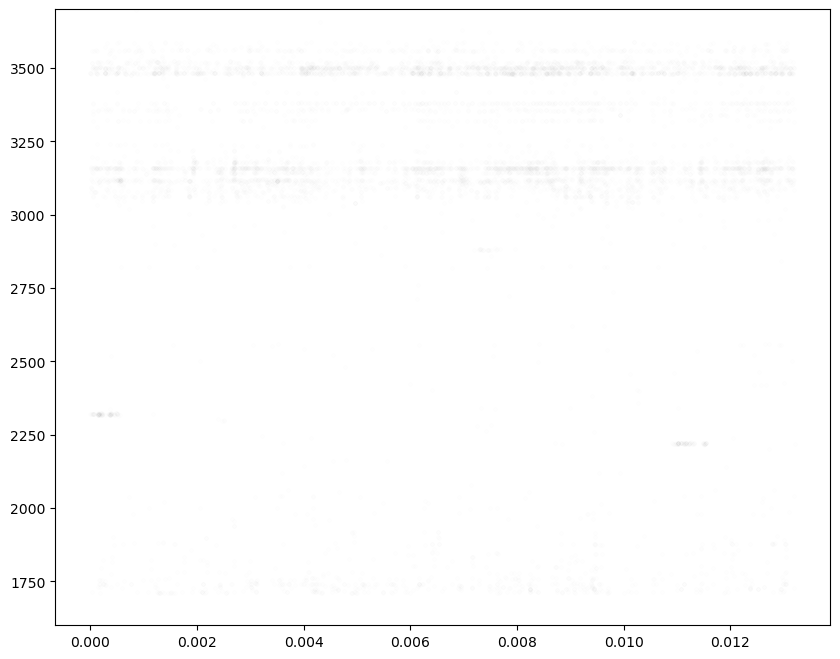

In [32]:
# check for drifts
probe = data.get_probe()
y_min = np.min(probe.contact_positions[:,1])
y_max = np.max(probe.contact_positions[:,1])

fs = data.sampling_frequency
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_ylim(y_min-100,y_max+100)
ax.scatter(peaks['sample_index'] / fs / 60 / 60, peak_locations['y'], color='k', marker='.',  alpha=0.002)

In [33]:
# we can also use the peak location estimates to have an insight of cluster separation before sorting
fig, ax = plt.subplots(figsize=(15, 40))
sw.plot_probe_map(data, ax=ax, with_channel_ids=True)
# ax.set_ylim(-100, 150)

ax.scatter(peak_locations['x'], peak_locations['y'], color='purple', alpha=0.002)

### Spike sorting

In [17]:
# Get default parameters for kilosort 3
ss.get_default_sorter_params('kilosort3')

{'detect_threshold': 6,
 'projection_threshold': [9, 9],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.2,
 'minfr_goodchannels': 0.2,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 300,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'do_correction': True,
 'NT': None,
 'AUCsplit': 0.8,
 'wave_length': 61,
 'keep_good_only': False,
 'skip_kilosort_preprocessing': False,
 'scaleproc': None,
 'save_rez_to_mat': False,
 'delete_tmp_files': True,
 'delete_recording_dat': False,
 'n_jobs': 8,
 'chunk_duration': '5s',
 'progress_bar': True}

In [18]:
# Set the path of kilosort3
kilosort_path = 'C:/Users/Tatsumi/Documents/GitHub/Kilosort'
ss.Kilosort3Sorter.set_kilosort3_path(kilosort_path)

Setting KILOSORT3_PATH environment variable for subprocess calls to: C:\Users\Tatsumi\Documents\GitHub\Kilosort


In [19]:
# Run kilosort3 with Docker
# Need to install Docker and pull spikeinterface/kilosort3 image first
# kilosort_outdir = 'C:/Users/Tatsumi/Documents/Data/KQTY_NP/32622'
kilosort_outdir = rez['processed'].joinpath('probe{}'.format(probe_id),'kilosort_output')
sorting = ss.run_sorter(sorter_name='kilosort3', recording=data,
                         output_folder=kilosort_outdir,
                        docker_image=True, verbose=True)

# # run kilosort3 without Docker: It returns an error
# sorting = ss.run_sorter('kilosort3', data, output_folder=rez['recording'] / 'kilosort_output',
#                         verbose=True)

DockerException: Error while fetching server API version: NpipeHTTPConnectionPool(host='localhost', port=None): Read timed out. (read timeout=60)

In [14]:
sorting

NameError: name 'sorting' is not defined

### Load sorted results

In [76]:
sorting.get_property('depth')

array([1740., 1700., 1700., 1740., 1780., 1780., 1740., 1740., 1780.,
       1820., 1820., 1840., 1880., 1880., 1880., 1860., 1860., 1920.,
       1900., 1940., 1940., 1960., 1960., 1980., 1980., 1980., 1980.,
       1980., 1980., 1980., 2000., 2000., 2040., 2040., 2040., 2040.,
       2040., 2040., 2060., 2060., 2080., 2080., 2080., 2080., 2060.,
       2060., 2060., 2060., 2060., 2060., 2060., 2080., 2140., 2140.,
       2160., 2120., 2120., 2140., 2120., 2140., 2120., 2140., 2140.,
       2140., 2120., 2160., 2140., 2160., 2160., 2160., 2140., 2140.,
       2160., 2180., 2160., 2140., 2140., 2180., 2180., 2180., 2220.,
       2220., 2180., 2220., 2220., 2220., 2180., 2200., 2160., 2180.,
       2200., 2220., 2260., 2260., 2260., 2260., 2260., 2260., 2220.,
       2260., 2260., 2240., 2260., 2260., 2300., 2300., 2300., 2300.,
       2300., 2300., 2300., 2300., 2300., 2300., 2320., 2340., 2340.,
       2400., 2400., 2420., 2480., 2500., 2520., 2520., 2500., 2500.,
       2560., 2560.,

In [81]:
sorting.get_property_keys()

['original_cluster_id',
 'Amplitude',
 'ContamPct',
 'KSLabel',
 'amp',
 'ch',
 'depth',
 'fr',
 'quality',
 'n_spikes',
 'sh']

In [84]:
sorting.get_property('n_spikes')

array([ 69599, 158458,  14946, 134942,  90529,  39457,  77655,   8490,
        94311, 108474, 289029,  17372,  15977,    178,   3793,  59962,
        13653,  15799,  34169,  10916,  32119,   7072,  19009,    266,
          406,    138,    162,   6829,    305,    258,   9006,  25626,
          751,    181,   1889,  29660,   1990,   4946,    224,  22847,
          472,  37441,    936, 104721,    178,    131,    127,    282,
          205,    248,    113,   7391,  25395,  13890,    126,  35134,
          550,    213,    155,    107,  52467,    303,    148,    112,
         8192,    155,   1030,    139,    154,    154,   4131,  25622,
          906,    978,    305, 185254,  31937, 104570,   8985,   7690,
          421,    133,    918,    378,    431,  34777,  12228,    177,
          104,    171,  46931,  37095,    131,  42415,    195,    261,
         2828,  61494,    113,    530,    169,    157,  60653,    118,
          198,    148,    235,    222,    132,    204,    107,    333,
      

In [86]:
sorting_new.get_property('n_spikes')

array([ 69599, 158458,  14946, 134942,  90529,  39457,  77655,   8490,
        94311, 108474, 289029,  17372,  15977,    178,   3793,  59962,
        13653,  15799,  34169,  10916,  32119,   7072,  19009,    266,
          406,    138,    162,   6829,    305,    258,   9006,  25626,
          751,    181,   1889,  29660,   1990,   4946,    224,  22847,
          472,  37441,    936, 104721,    178,    131,    127,    282,
          205,    248,    113,   7391,  25395,  13890,    126,  35134,
          550,    213,    155,    107,  52467,    303,    148,    112,
         8192,    155,   1030,    139,    154,    154,   4131,  25622,
          906,    978,    305, 185254,  31937, 104570,   8985,   7690,
          421,    133,    918,    378,    431,  34777,  12228,    177,
          104,    171,  46931,  37095,    131,  42415,    195,    261,
         2828,  61494,    113,    530,    169,    157,  60653,    118,
          198,    148,    235,    222,    132,    204,    107,    333,
      

In [78]:
output_folder = rez['processed'].joinpath('probe{}'.format(probe_id),'kilosort_output')
sorting_new = ss.read_sorter_folder(output_folder, raise_error=True)
sorting_new

C:\Users\Tatsumi\AppData\Local\anaconda3\envs\si_env\lib\site-packages\spikeinterface\core\basesorting.py:146: UserWarning: Some spikes are exceeding the recording's duration! Removing these excess spikes with `spikeinterface.curation.remove_excess_spikes()` Might be necessary for further postprocessing.
  warnings.warn(


KiloSortSortingExtractor: 388 units - 1 segments - 30.0kHz

## Post processing

All the postprocessing step is based on the WaveformExtractor object.  
This object combines a recording and a sorting object and extracts some waveform snippets (500 by default) for each units.

Note that we use th`e sparse=Tr`ue option. This option is important because the waveforms will be extracted only for a few channels around the main channel of each unit. This saves tons of disk space and speeds up the waveforms extraction and further processing.

In [16]:
data.is_filtered()

True

The recording is not filtered, you must filter it using `bandpass_filter()`.If the recording is already filtered, you can also do `recording.annotate(is_filtered=True).
If you trully want to extract unfiltered waveforms, use `allow_unfiltered=True`.

In [17]:
sorting_curated = scur.remove_excess_spikes(sorting,data)

In [19]:
job_kwargs = dict(n_jobs=40, chunk_duration='5s', progress_bar=True)
# Extract waveforms
we = si.extract_waveforms(data, sorting_curated, folder=rez['processed'].joinpath('probe{}'.format(probe_id),'waveforms_kilosort3'),
                          sparse=True, max_spikes_per_unit=500, ms_before=1.5,ms_after=2.,
                          **job_kwargs)

extract waveforms shared_memory:   0%|          | 0/1378 [00:01<?, ?it/s]

extract waveforms shared_memory:   0%|          | 0/1378 [00:00<?, ?it/s]

extract waveforms memmap:   0%|          | 0/1378 [00:00<?, ?it/s]

In [20]:
# the WaveformExtractor contains all information and is persistent on disk
print(we)
print(we.folder)

WaveformExtractor: 192 channels - 388 units - 1 segments
  before:45 after:60 n_per_units:500 - sparse
Z:\users\Tatsumi\data\NP_Kevin\GridBat\32622\flight_room\231007\20231007_133453.rec\processed\probe1\waveforms_kilosort3


In [ ]:
# the waveform extractor can be easily loaded back from folder
# we = si.load_waveforms(rez['processed'].joinpath('waveforms_kilosort2.5'))
# we

In [21]:
we_noise_levels = spost.compute_noise_levels(we)

In [22]:
we_spike_amplitudes = spost.compute_spike_amplitudes(we, **job_kwargs)

extract amplitudes:   0%|          | 0/1378 [00:00<?, ?it/s]

In [23]:
we_unit_locations = spost.compute_unit_locations(we)

In [24]:
we_spike_locations = spost.compute_spike_locations(we)

localize peaks using center_of_mass:   0%|          | 0/1378 [00:00<?, ?it/s]

In [25]:
we_corr, corr_bin = spost.compute_correlograms(we)

In [26]:
we_template_similarity = spost.compute_template_similarity(we)

In [27]:
we_isi_histogram, isi_bin = spost.compute_isi_histograms(we)

## Quality metrics

We have a single function `compute_quality_metrics(WaveformExtractor)` that returns a `pandas.Dataframe` with the desired metrics.  


Some metrics are based on PCA (like 'isolation_distance', 'l_ratio', 'd_prime') and require to estimate PCA for their computation. This can be achieved w  i`h:

si.compute_principal_components(waveform_extr`actor)

In [71]:
# PCA
pca = spost.compute_principal_components(waveform_extractor=we, n_components=5, mode='by_channel_local')

Fitting PCA:   0%|          | 0/442 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/442 [00:00<?, ?it/s]

In [28]:
metrics = sqm.compute_quality_metrics(waveform_extractor=we)

C:\Users\Tatsumi\AppData\Local\anaconda3\envs\si_env\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:590: UserWarning: Units [14, 26, 27, 28, 29, 31, 32, 36, 41, 43, 48, 49, 50, 51, 52, 53, 55, 60, 63, 64, 65, 67, 68, 69, 74, 76, 78, 80, 87, 94, 95, 98, 99, 103, 104, 105, 108, 110, 111, 114, 116, 117, 119, 120, 122, 123, 124, 125, 126, 127, 128, 138, 140, 157, 167, 168, 169, 191, 192, 193, 199, 204, 206, 207, 208, 211, 212, 214, 215, 216, 218, 219, 222, 223, 228, 231, 233, 234, 235, 236, 265, 273, 274, 275, 276, 277, 278, 279, 280, 282, 296, 297, 299, 302, 305, 306, 307, 313, 314, 316, 320, 321, 335, 336, 339, 341, 346, 347, 348, 359, 369, 377, 396, 401, 404] have too few spikes and amplitude_cutoff is set to NaN
  warnings.warn(f"Units {nan_units} have too few spikes and " "amplitude_cutoff is set to NaN")


In [111]:
good_units = metrics.amplitude_cutoff.notna()
good_units

0       True
1      False
2       True
4      False
5       True
       ...  
475     True
476     True
477     True
478    False
479     True
Name: amplitude_cutoff, Length: 442, dtype: bool

C:\Users\Tatsumi\AppData\Local\anaconda3\envs\si_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Tatsumi\AppData\Local\anaconda3\envs\si_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tatsumi\AppData\Local\anaconda3\envs\si_env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


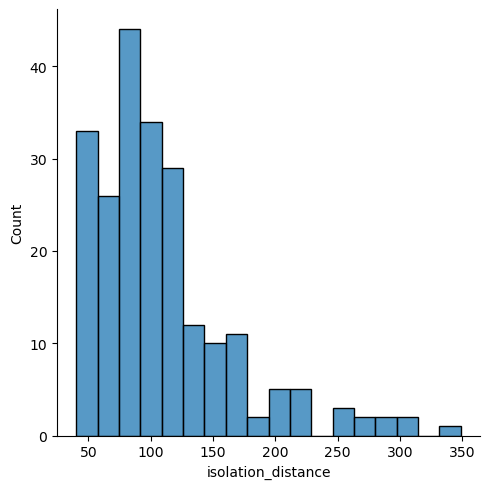

In [117]:
import seaborn as sns
# Plot good unit
iso_dist = metrics.isolation_distance[good_units]
ax = sns.displot(iso_dist)

C:\Users\Tatsumi\AppData\Local\anaconda3\envs\si_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Tatsumi\AppData\Local\anaconda3\envs\si_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tatsumi\AppData\Local\anaconda3\envs\si_env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


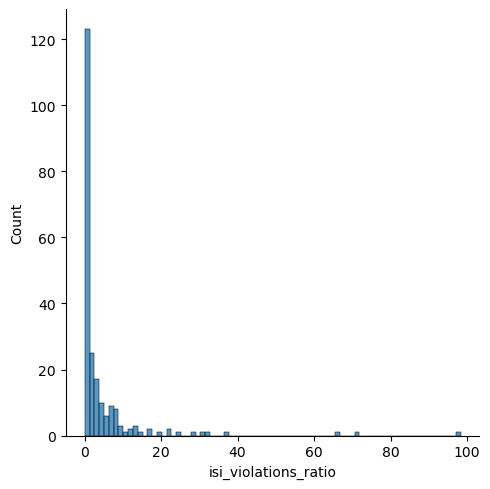

In [118]:
isi_violation = metrics.isi_violations_ratio[good_units]
ax = sns.displot(isi_violation)

### Curation using metrics

In [55]:
amplitude_cutoff_thresh = 0.1
isi_violations_ratio_thresh = 1
presence_ratio_thresh = 0.9

our_query = f"(amplitude_cutoff < {amplitude_cutoff_thresh}) & (isi_violations_ratio < {isi_violations_ratio_thresh}) & (presence_ratio > {presence_ratio_thresh})"
print(our_query)

(amplitude_cutoff < 0.1) & (isi_violations_ratio < 1) & (presence_ratio > 0.9)


### Export final results to disk folder and visualize with sorting view

In [56]:
we_clean = we.select_units(keep_unit_ids, new_folder=rez['processed'].joinpath('waveforms_clean'))
we_clean

NameError: name 'keep_unit_ids' is not defined

In [ ]:
# export spike sorting report to a folder
sexp.export_report(we_clean, rez['processed'].joinpath('report'), format='png')

In [ ]:
# Load exported report from the folder
# we_clean = si.load_waveforms(rez['processed'].joinpath('report'))
# we_clean

In [ ]:
# push the results to sortingview webased viewer
sw.plot_sorting_summary(we_clean, backend='sortingview')

## Check waveforms

In [54]:
help(we.select_units)

Help on method select_units in module spikeinterface.core.waveform_extractor:

select_units(unit_ids, new_folder=None, use_relative_path: bool = False) -> 'WaveformExtractor' method of spikeinterface.core.waveform_extractor.WaveformExtractor instance
    Filters units by creating a new waveform extractor object in a new folder.
    
    Extensions are also updated to filter the selected unit ids.
    
    Parameters
    ----------
    unit_ids : list or array
        The unit ids to keep in the new WaveformExtractor object
    new_folder : Path or None
        The new folder where selected waveforms are copied
    
    Returns
    -------
    we :  WaveformExtractor
        The newly create waveform extractor with the selected units



In [65]:
unit_id = 202
waveforms = we.get_waveforms(unit_id)
template = we.get_template(unit_id, mode='median')

In [61]:
print(waveform_unit.shape)
print(waveform_unit.mean(0).shape) # num_spikes x num_samples x num_channels

(500, 105, 18)
(105, 18)


In [19]:
sw.plot_unit_waveforms(we,unit_id)

NameError: name 'we' is not defined

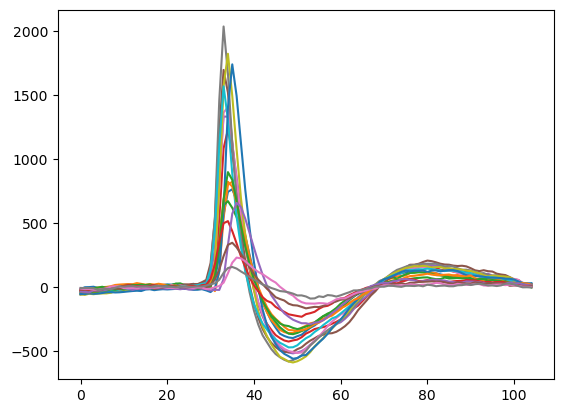

In [64]:
plt.plot(waveform_unit.mean(0))
plt.show()

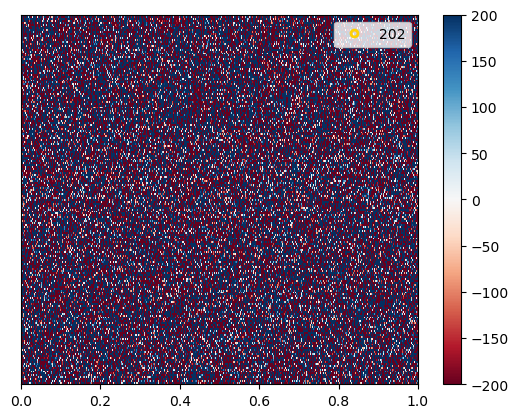

In [63]:
sw.plot_spikes_on_traces(we,unit_ids=[202])

In [44]:
channel_ids = data_int16.channel_ids

In [45]:
data_int16.get_traces(start_frame=0,end_frame=100,segment_index=0,channel_ids=channel_ids[:4])

array([[  960,   576,  2752,  1024],
       [  768,    64,   320,     0],
       [ 2112,  -192,  -128,  1024],
       [ 1792,  -192,   192,  1280],
       [  448,  -192, -1152,  1152],
       [  128,  1280, -1088,   640],
       [ 1728,  1088,  -576,   960],
       [    0,   832,  -960,   256],
       [-1152, -1472,   256, -1408],
       [-1024, -1280,   256, -2112],
       [-1152, -1472,  -320, -1856],
       [ -960,   128,  -384,  -576],
       [  256,   640,   256,  -192],
       [  640,  1856,   960,   -64],
       [  384,  1600,   768,  1408],
       [ -576,   192,   576,  1152],
       [ -896, -1600,  1216,   768],
       [ -320, -1088,   704,   640],
       [  768,   320,  1600,  1984],
       [  448,   448,   384,   704],
       [ -128,  -128, -1216,   576],
       [  384,   384, -3392,   384],
       [  384,   768, -2176,  -640],
       [-1472,   256,  -576, -1408],
       [-2880,  -256,  -448,  -704],
       [-1728,  -256,  -704,  -768],
       [ -512,  -256,   128, -2304],
 

In [46]:
channel_ids[:4]

array([0, 1, 2, 3])

In [49]:
probe = data_int16.get_probe()

In [50]:
probe.contact_positions[:4]

array([[   8., 1700.],
       [ -24., 1700.],
       [  24., 1720.],
       [  -8., 1720.]])